# My own face detector

## Instalar dependencias

In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

In [ ]:
!pip install keras_vggface keras tensorflow keras_applications setuptools

In [ ]:
!pip uninstall -y keras
!pip install keras==2.12

In [ ]:
!pip install mtcnn

## Generate own dataset

In [1]:
import cv2
import os
import keras
import matplotlib.pyplot as plt
import matplotlib
import mtcnn
import tensorflow as tf
import numpy as np
import keras_vggface.utils
from PIL import Image
from keras_vggface.vggface import VGGFace
from keras.layers import Flatten, Dense

In [2]:
PROJECT_PATH = os.path.join(os.getcwd(), 'my-own-face-detector-project')

In [3]:
DATASET_ID = input("Enter de ID:")

Enter de ID: fernando


In [ ]:
DATASET_ID_DIRECTORY = os.path.join(PROJECT_PATH, 'datasets', DATASET_ID)

isExist = os.path.exists(DATASET_ID_DIRECTORY)

if isExist:
    print("Directory exists")
else:
    os.makedirs(DATASET_ID_DIRECTORY)
    print("Created directory")

In [ ]:
camera = cv2.VideoCapture(0)
number_of_sample_faces = 200

HAARCASCADE_PATH = os.path.join(PROJECT_PATH, 'haarcascade_frontalface_default.xml')

face_detect = cv2.CascadeClassifier(HAARCASCADE_PATH)

for i in range(number_of_sample_faces):
    ret, img = camera.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detect.detectMultiScale(gray, 1.3, 5)
    for x, y, w, h in faces:
        filename = os.path.join(DATASET_ID_DIRECTORY + "/" + str(i+1) + ".jpg")
        cv2.imwrite(filename, img[y : y + h, x : x + w])
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.waitKey(75)

    cv2.imshow("Face", img)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

camera.release()
cv2.destroyAllWindows()

## Normalize

We already have our custom dataset, but before we have to normalize them, in order that, the model that we're going to use, can accept out dataset

In [4]:
DATASET_PATH = os.path.join(PROJECT_PATH, 'datasets')

In [ ]:
import os
import random
import shutil

def seleccionar_imagenes(path, num_imagenes_a_mantener):
    # Lista todos los archivos en el directorio
    archivos = os.listdir(path)
    
    # Filtra solo los archivos que son imágenes
    imagenes = [archivo for archivo in archivos if archivo.endswith((".jpg", ".jpeg", ".png", ".gif"))]
    
    # Verifica si hay menos imágenes que el número especificado a mantener
    if len(imagenes) <= num_imagenes_a_mantener:
        print("¡No hay suficientes imágenes para eliminar!")
        return
    
    # Selecciona aleatoriamente las imágenes a mantener
    imagenes_a_mantener = random.sample(imagenes, num_imagenes_a_mantener)
    
    # Elimina las imágenes que no están en la lista de imágenes a mantener
    for imagen in imagenes:
        if imagen not in imagenes_a_mantener:
            ruta_completa = os.path.join(path, imagen)
            os.remove(ruta_completa)
            print(f"Eliminando: {imagen}")

# Ruta al directorio que contiene las imágenes
ruta_directorio = "/Users/devrrior/Downloads/data/vehicles"

# Número de imágenes a mantener
num_imagenes_a_mantener = 15

# Llama a la función para seleccionar y eliminar imágenes
seleccionar_imagenes(ruta_directorio, num_imagenes_a_mantener)


### Funcion para redimensionar imagenes

In [ ]:
def resize_images(path, width, height):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".jpg"):
                dataset_path = os.path.join(root, file)
                img = cv2.imread(dataset_path)
                img = cv2.resize(img, (width, height))
                cv2.imwrite(dataset_path, img)
                print(f"Image {file} resized")

In [ ]:
resize_images(DATASET_PATH,224,224)

### Funcion para convertir a b/n imagenes

In [ ]:
def convert_to_grayscale(path):
    files = os.listdir(path)
    
    images = [file for file in files if file.endswith((".jpg", ".jpeg", ".png", ".gif"))]
    
    for image in images:
        image_path = os.path.join(path, image)
        img = cv2.imread(image_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join(path, f"bn_{image}"), gray_img)
        print(f"Image {image} converted to grayscale")

directory_path = "/Users/devrrior/Repos/my_lab_ai/notebooks/my-own-face-detector-project/datasets/unknown"

convert_to_grayscale(directory_path)

### Función para renombrar imagenes de 1.jpg a n.jpg

In [ ]:
def rename_images(path):
    files = os.listdir(path)
    
    images = [file for file in files if file.endswith((".jpg", ".jpeg", ".png", ".gif"))]
    
    counter = 1
    
    for image in images:
        old_path = os.path.join(path, image)
        extension = os.path.splitext(image)[1]
        new_name = f"{counter}{extension}"
        new_path = os.path.join(path, new_name)
        os.rename(old_path, new_path)
        print(f"Renaming {image} to {new_name}")
        counter += 1

directory_path = "/Users/devrrior/Repos/my_lab_ai/notebooks/my-own-face-detector-project/datasets/unknown"

rename_images(directory_path)


## Entrenar AI Model

In [89]:
train_dataset = keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    batch_size=8,
    image_size=(224, 224),
)

Found 265 files belonging to 2 classes.


In [6]:
class_names = train_dataset.class_names
class_names

['fernando', 'unknown']

In [7]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.2),
    ]
)

In [8]:
vggface_resnet_base = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))

In [9]:
nb_class = 2

vggface_resnet_base.trainable = False
last_layer = vggface_resnet_base.get_layer("avg_pool").output

inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = vggface_resnet_base(x)
x = Flatten(name='flatten')(x)
out = Dense(nb_class, activation='softmax', name="classifier")(x)

custom_vgg_model = keras.Model(inputs, out)

base_learning_rate = 0.0001

custom_vgg_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [83]:
history = custom_vgg_model.fit(train_dataset, epochs=20)

Epoch 1/20
34/34 [==============================] - 10s 270ms/step - loss: 0.0655 - accuracy: 0.9849
Epoch 2/20
34/34 [==============================] - 9s 256ms/step - loss: 0.0680 - accuracy: 0.9887
Epoch 3/20
34/34 [==============================] - 8s 233ms/step - loss: 0.0595 - accuracy: 0.9887
Epoch 4/20
34/34 [==============================] - 8s 246ms/step - loss: 0.0541 - accuracy: 0.9925
Epoch 5/20
34/34 [==============================] - 9s 254ms/step - loss: 0.0609 - accuracy: 0.9925
Epoch 6/20
34/34 [==============================] - 9s 258ms/step - loss: 0.0574 - accuracy: 0.9962
Epoch 7/20
34/34 [==============================] - 9s 260ms/step - loss: 0.0627 - accuracy: 0.9925
Epoch 8/20
34/34 [==============================] - 9s 265ms/step - loss: 0.0663 - accuracy: 0.9925
Epoch 9/20
34/34 [==============================] - 9s 258ms/step - loss: 0.0543 - accuracy: 0.9887
Epoch 10/20
34/34 [==============================] - 12s 359ms/step - loss: 0.0561 - accuracy: 0.99

In [84]:
GENERATED_MODEL_PATH = os.path.join(PROJECT_PATH, 'model.h5')

In [85]:
custom_vgg_model.save(GENERATED_MODEL_PATH)

## Time to predict

In [15]:
TEST_PATH = os.path.join(PROJECT_PATH, 'test')

In [16]:
face_detector = mtcnn.MTCNN()

In [71]:
def load_images(path, width, height):
    image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    processed_images = []

    for image_file in image_files:
        if image_file.endswith('.jpg') or image_file.endswith('.jpeg'):
            image_path = os.path.join(path, image_file)
            print(image_path)
            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
            img_roi = face_detector.detect_faces(image)
    
            if img_roi:
                x1, y1, width, height = img_roi[0]["box"]
                x2, y2 = x1 + width, y1 + height
                face = image[y1:y2, x1:x2]
                face = cv2.resize(face, (224,224))
    
                processed_images.append(face)
                print(face.shape)
                plt.imshow(face)
                plt.show()

    processed_images_array = np.array(processed_images)

    return processed_images_array

/Users/devrrior/Repos/my_lab_ai/notebooks/my-own-face-detector-project/test/4.jpg
1/1 [==============================] - 0s 16ms/step
(224, 224, 3)


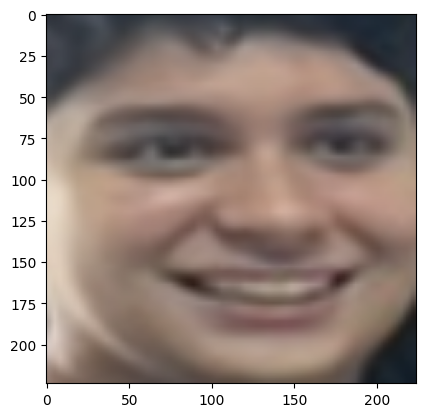

/Users/devrrior/Repos/my_lab_ai/notebooks/my-own-face-detector-project/test/2.jpg
1/1 [==============================] - 0s 13ms/step
(224, 224, 3)


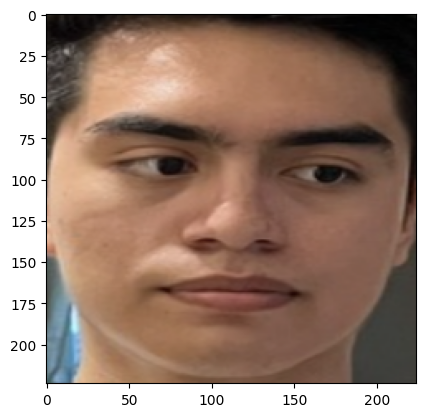

/Users/devrrior/Repos/my_lab_ai/notebooks/my-own-face-detector-project/test/3.jpg
1/1 [==============================] - 0s 11ms/step
(224, 224, 3)


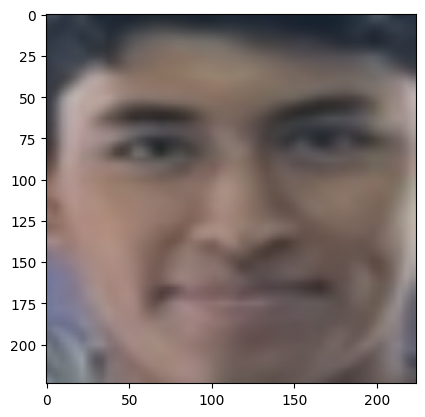

/Users/devrrior/Repos/my_lab_ai/notebooks/my-own-face-detector-project/test/1.jpg
1/1 [==============================] - 0s 14ms/step
(224, 224, 3)


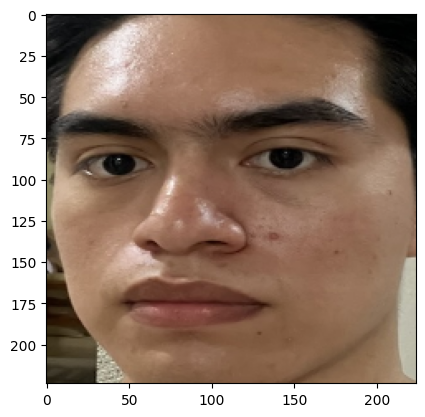

In [72]:
samples1 = load_images('/Users/devrrior/Repos/my_lab_ai/notebooks/my-own-face-detector-project/test', 224, 224)

In [86]:
custom_vgg_model = tf.keras.models.load_model(GENERATED_MODEL_PATH)

In [87]:
prob_model = tf.keras.Sequential([custom_vgg_model, tf.keras.layers.Softmax()])

In [20]:
face.ndim

3

In [21]:
samples = np.array([face])

In [88]:
predictions = prob_model.predict(samples1)
print(predictions)

1/1 [==============================] - 1s 521ms/step
[[3.5649689e-04 9.9964345e-01]
 [6.2253797e-01 3.7746200e-01]
 [1.6114148e-01 8.3885849e-01]
 [5.8595353e-01 4.1404644e-01]]


In [78]:
predictions

array([[4.1478299e-04, 9.9958515e-01],
       [4.8792279e-01, 5.1207727e-01],
       [3.9187086e-01, 6.0812920e-01],
       [3.3376637e-01, 6.6623372e-01]], dtype=float32)